# Homework 5 - Neural Newtorks

__Due Date:__ 2024-11-20 at 8:30 AM PT

__Name:__ Nolan Yager


In [13]:
# Pre-prep

# Import Packages: 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Current WD:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\nyager\Desktop\YagerMLCode\MachineLearning_Fall24\homework


Preparation:
We're using the same [data file](https://github.com/gabehassler/PRGS-Intro-to-ML-2024/blob/main/data/processed/svi_covid.csv) from GitHub as the last assignment in the _data/processed_ folder.

In [14]:
# Loading data
covid_data = pd.read_csv("data/processed/svi_covid.csv")

print(covid_data.head(5))

   Unnamed: 0  fips_code  total_cases_per_100k  total_deaths_per_100k  \
0           1       1001          33888.123075             399.925120   
1           2       1003          30212.064090             313.169394   
2           3       1005          30477.951521             418.056840   
3           4       1007          36623.073120             498.853984   
4           5       1009          31944.750072             441.796300   

   E_TOTPOP  EP_POV150  EP_UNEMP  EP_HBURD  EP_NOHSDP  EP_UNINSUR  ...  \
0     58761       20.2       2.8      19.7        9.6         7.4  ...   
1    233420       18.3       3.4      23.2        8.4         9.3  ...   
2     24877       37.7       5.8      25.1       23.5        10.7  ...   
3     22251       29.0       8.7      23.2       21.1         8.4  ...   
4     59077       22.9       6.0      19.4       18.2        10.2  ...   

   EP_DISABL  EP_SNGPNT  EP_LIMENG  EP_MINRTY  EP_MUNIT  EP_MOBILE  EP_CROWD  \
0       16.4        5.6        0.4  

1. Use a simple neural network to predict the number of per-capita COVID-19 deaths in each county in the US using the SVI variables.
The outcome variable is `total_deaths_per_100k` and the predictor variables are `EP_POV150, EP_UNEMP, EP_HBURD, EP_NOHSDP, EP_UNINSUR, EP_AGE65, EP_AGE17, EP_DISABL, EP_SNGPNT, EP_LIMENG, EP_MINRTY, EP_MUNIT, EP_MOBILE, EP_CROWD, EP_NOVEH, EP_GROUPQ, EP_NOINT`.
The neural network should have one hidden layer with 10 nodes and use the ReLU activation function.
Plot the predicted values against the true values.
What is the mean squared error of the predictions in the test set?

In [15]:
# PREPARATION: 

# Specifying predictor and outcome 
predictor_columns = [
    'EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR',
    'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG',
    'EP_MINRTY', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH',
    'EP_GROUPQ', 'EP_NOINT'
]
outcome_column = 'total_deaths_per_100k'

# Data prep (making it a numpy array)
X = covid_data[predictor_columns].values
y = covid_data[outcome_column].values

# Split the data: (note here I am using 80/20, stack overflow noted this is a standard starting point)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize it
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [16]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [17]:
# NEURAL NETWORK: 

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(len(predictor_columns), 10) # check it out we got 10 nodes
        self.output = nn.Linear(10, 1) # output layer, 1 node. 
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))  # ReLU activation function
        x = self.output(x)  # Output layer
        return x    

# Creating model
model_simple = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_simple.parameters(), lr=0.01) 

print(model_simple)

SimpleNN(
  (hidden): Linear(in_features=17, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In [18]:
# TRAINING AND EVALUATION

# Training model_simple
epochs = 100
for epoch in range(epochs):
    model_simple.train()  # model in training mode
    optimizer.zero_grad()  
    predictions = model_simple(X_train_tensor) 
    loss = criterion(predictions, y_train_tensor) 
    loss.backward()  
    optimizer.step() 


# Evaluating the model
model_simple.eval()  # model in evaluation mode
with torch.no_grad():  
    test_predictions = model_simple(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')


Test Loss: 174288.375


1.b. Plot the predicted values against the true values.

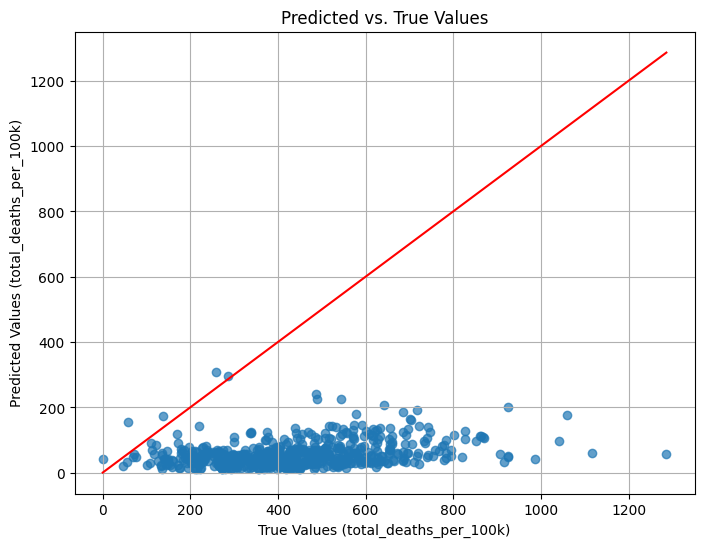

In [20]:
# Switch to evaluation mode
model_simple.eval()

# Get predictions on the test set
with torch.no_grad(): # no gradient
    predictions = model_simple(X_test_tensor)
    predictions = predictions.numpy() # changing these to a numpy array
    y_test_np = y_test_tensor.numpy()  

# Plotting:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, predictions, alpha=0.7)
plt.xlabel('True Values (total_deaths_per_100k)')
plt.ylabel('Predicted Values (total_deaths_per_100k)')
plt.title('Predicted vs. True Values')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red')  # Diagonal line
plt.grid(True)
plt.show()

MSE of test set: 


2. Repeat the analysis from the previous question, but this time use a more complicated neural network with more hidden layers and/or more nodes in the hidden layers.
You should experiment with different architectures and activation functions to see what works best.
Plot the predicted values against the true values.
What is the mean squared error of the predictions in the test set?

3. Compare the predictions of the neural network in Question 2 to the predictions of the regression tree from the previous assignment. Which model would you use to predict the number of per-capita COVID-19 deaths? Why?
Which model would you use to understand the relationship between the SVI variables and the number of per-capita COVID-19 deaths? Why?